In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

%matplotlib inline

### Loading the Book Ratings Dataset

In [36]:
ratings = pd.read_csv('../raw-data/BX-Book-Ratings.csv', encoding='iso-8859-1', sep = ';')
ratings.columns = ['user_id', 'isbn', 'book_rating']

In [37]:
print(ratings.dtypes)
print()
print(ratings.head())
print()
print("Data Points :", ratings.shape[0])

user_id         int64
isbn           object
book_rating     int64
dtype: object

   user_id        isbn  book_rating
0   276725  034545104X            0
1   276726  0155061224            5
2   276727  0446520802            0
3   276729  052165615X            3
4   276729  0521795028            6

Data Points : 1149780


### Loading the Books Dataset

In [38]:
books = pd.read_csv('../raw-data/BX-Books.csv', sep=';', encoding = 'iso-8859-1', dtype =str)
del books['Image-URL-L']
del books['Image-URL-M']
del books['Image-URL-S']
del books['Book-Author']
del books['Publisher']

Some Books don't have unique ISBN, creating a 1:1 maping between books-title and ISBN

In [39]:
print('Number of Books == Number of ISBN ? ', books["Book-Title"].nunique() == books["ISBN"].nunique())
book_dict = books[["Book-Title","ISBN"]].set_index("Book-Title").to_dict()["ISBN"]
books['new_isbn'] = books["Book-Title"].apply(lambda x: book_dict[x])
print('Number of Books == Number of ISBN ? ', books["Book-Title"].nunique() == books["new_isbn"].nunique())

Number of Books == Number of ISBN ?  False
Number of Books == Number of ISBN ?  True


In [40]:
books['isbn'] = books['new_isbn']

del books['ISBN']
del books['new_isbn']

Removing ratings equal to zero, since Book Crossing Dataset has rating scale from 1-10. Taking Inner Join with books dataframe to maintain books whose details exist.

In [41]:
newdf = ratings[ratings.book_rating>0]
joined = books.merge(newdf, on ='isbn')
print(newdf.shape)

(433671, 3)


Book Crossing Dataset is a very sparse Dataset with sparsity of more than 99.99%. In order to choose a small subset of dataset with constraints given in the dataset, we selected top 100 items which have been rated the most and took intersection with top 20000 users who have given ratings to more books. Further we remove all users who rated only one book to make the data more denser. This gave a dataset with 2517 users and 100 items with 8242 data points. In order to verify the scalability of our model we created different dataset with increasing book counts (150, 200, 300, 500)

In [42]:
datasets = []
for j in [100, 150, 200, 300, 500]:
    df = joined.groupby('isbn').count().sort_values('user_id', ascending =False)[0:j].index.values
    test = joined.groupby('user_id').count().sort_values('isbn', ascending = False)[:20000].index.values
    newdf = joined[joined.user_id.isin(test) & joined.isbn.isin(df)]
    data  = newdf[newdf['user_id'].isin(newdf['user_id'].value_counts()[newdf['user_id'].value_counts()>1].index)]
    print("users books")
    print(data.user_id.nunique(), data.isbn.nunique())
    print()
    print(data.shape)
    print()
    print(data.groupby('user_id').count().sort_values('isbn', ascending = False).mean())
    print()
    datasets.append(data)

users books
2517 100

(8242, 5)

Book-Title             3.274533
Year-Of-Publication    3.274533
isbn                   3.274533
book_rating            3.274533
dtype: float64

users books
3086 150

(10829, 5)

Book-Title             3.509073
Year-Of-Publication    3.509073
isbn                   3.509073
book_rating            3.509073
dtype: float64

users books
3543 200

(13271, 5)

Book-Title             3.745696
Year-Of-Publication    3.745696
isbn                   3.745696
book_rating            3.745696
dtype: float64

users books
4280 300

(17160, 5)

Book-Title             4.009346
Year-Of-Publication    4.009346
isbn                   4.009346
book_rating            4.009346
dtype: float64

users books
5282 500

(23181, 5)

Book-Title             4.388679
Year-Of-Publication    4.388679
isbn                   4.388679
book_rating            4.388679
dtype: float64



Taking Dataset with 100 items

In [43]:
data = datasets[0]
rows = data.user_id.unique()
cols = data['Book-Title'].unique()
print(data.user_id.nunique(), data.isbn.nunique())
data = data[['user_id', 'Book-Title', 'book_rating']]

2517 100


In [44]:
print("Sparsity :", 100 - (data.shape[0]/(len(cols)*len(rows)) * 100))

Sparsity : 96.72546682558601


In [45]:
idict  = dict(zip(cols, range(len(cols))))
udict = dict(zip(rows, range(len(rows))))

data.user_id = [
    udict[i] for i in data.user_id
]
data['Book-Title'] = [
    idict[i] for i in data['Book-Title']
]

nmat = data.as_matrix()


/Users/janakajain/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/Users/janakajain/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [46]:
nmat

array([[   0,    0,   10],
       [   1,    0,    5],
       [   2,    0,    8],
       ..., 
       [2081,   99,    8],
       [ 288,   99,    8],
       [2088,   99,    8]])

#### Function for Evaluation Metrics: MAE and RMSE

In [47]:
def rmse(ypred, ytrue):
    ypred = ypred[ytrue.nonzero()].flatten()
    ytrue = ytrue[ytrue.nonzero()].flatten()
    return np.sqrt(mean_squared_error(ypred, ytrue))

def mae(ypred, ytrue):
    ypred = ypred[ytrue.nonzero()].flatten()
    ytrue = ytrue[ytrue.nonzero()].flatten()
    return mean_absolute_error(ypred, ytrue)

In [48]:
print('------ Naive(baseline) ------')

------ Naive(baseline) ------


Our Naive Baseline for any user i, item j prediction is to assign it with (sum of mean rating given by user i (umean[i]), mean rating received by item j (imean[j]) substracting average rating over entire dataset (amean)) 

In [49]:
def predict_naive(user, item):
    prediction = imean1[item] + umean1[user] - amean1
    return prediction

In [50]:
x1, x2 = train_test_split(nmat, test_size = 0.2)
naive = np.zeros((len(rows),len(cols)))
for row in x1:
    naive[row[0], row[1]] = row[2]

predictions = []
targets = []

amean1 = np.mean(naive[naive!=0])
umean1 = sum(naive.T) / sum((naive!=0).T)
imean1 = sum(naive) / sum((naive!=0))

umean1 = np.where(np.isnan(umean1), amean1, umean1)
imean1 = np.where(np.isnan(imean1), amean1, imean1)


print('Naive...')
for row in x2:
    user, item, actual = row[0], row[1], row[2]
    predictions.append(predict_naive(user, item))
    targets.append(actual)

print('rmse %.4f' % rmse(np.array(predictions), np.array(targets)))
print('mae %.4f' % mae(np.array(predictions), np.array(targets)))
print()

Naive...
rmse 1.6097
mae 1.1384



/Users/janakajain/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in true_divide


Following are the functions to calculate pairwise similarity between two items : Cosine, Adjusted Cosine, Euclidean, Pearson Corelation.

In [51]:
def cos(mat, a, b):
    if a == b:
        return 1
    aval = mat.T[a].nonzero()
    bval = mat.T[b].nonzero()
    corated = np.intersect1d(aval, bval)
    if len(corated) == 0:
        return 0
    avec = np.take(mat.T[a], corated)
    bvec = np.take(mat.T[b], corated)
    val = 1 - cosine(avec, bvec)
    if np.isnan(val):
        return 0
    return val

In [52]:
def adjcos(mat, a, b, umean):
    if a == b:
        return 1
    aval = mat.T[a].nonzero()
    bval = mat.T[b].nonzero()
    corated = np.intersect1d(aval, bval)
    if len(corated) == 0:
        return 0
    avec = np.take(mat.T[a], corated)
    bvec = np.take(mat.T[b], corated)
    avec1 = avec - umean[corated]
    bvec1 = bvec - umean[corated]
    val = 1 - cosine(avec1, bvec1)
    if np.isnan(val):
        return 0
    return val

In [53]:
def pr(mat, a, b, imean):
    if a == b:
        return 1
    aval = mat.T[a].nonzero()
    bval = mat.T[b].nonzero()
    corated = np.intersect1d(aval, bval)
    if len(corated) < 2:
        return 0
    avec = np.take(mat.T[a], corated)
    bvec = np.take(mat.T[b], corated)
    avec1 = avec - imean[a]
    bvec1 = bvec - imean[b]
    val = 1 - cosine(avec1, bvec1)
    if np.isnan(val):
        return 0
    return val

In [54]:
def euc(mat, a, b):
    if a == b:
        return 1
    aval = mat.T[a].nonzero()
    bval = mat.T[b].nonzero()
    corated = np.intersect1d(aval, bval)
    if len(corated) == 0:
        return 0
    avec = np.take(mat.T[a], corated)
    bvec = np.take(mat.T[b], corated)
    dist = np.sqrt(np.sum(a-b)**2)
    val = 1/(1+dist)
    if np.isnan(val):
        return 0
    return val

Function item similar returns matrix of pairwise similarity between all items based on the option provided. Also return amean (global mean rating), umean (average rating of each user), imean (Average rating of each item)

In [55]:
def itemsimilar(mat, option):
    amean = np.mean(mat[mat!=0])
    umean = sum(mat.T) / sum((mat!=0).T)
    imean = sum(mat) / sum((mat!=0))
    
    umean = np.where(np.isnan(umean), amean, umean)
    imean = np.where(np.isnan(imean), amean, imean)
    
    n = mat.shape[1]
    sim_mat = np.zeros((n, n))
    
    if option == 'pr':
        #print("PR")
        for i in range(n):
            for j in range(n):
                sim_mat[i][j] = pr(mat, i, j, imean)
        sim_mat = (sim_mat + 1)/2
    elif option == 'cos':
        #print("COS")
        for i in range(n):
            for j in range(n):
                sim_mat[i][j] = cos(mat, i, j)
    elif option == 'adjcos':
        #print("ADJCOS")
        for i in range(n):
            for j in range(n):
                sim_mat[i][j] = adjcos(mat, i, j, umean)
        sim_mat = (sim_mat + 1)/2
    elif option == 'euc':
        #print("EUCLIDEAN")
        for i in range(n):
            for j in range(n):
                sim_mat[i][j] = euc(mat, i, j)
    else:
        #print("Hello")
        sim_mat = cosine_similarity(mat.T)
    
    return sim_mat, amean, umean, imean
        

Predict function is used to get recommended rating by user i for item j.

In [56]:
def predict(user, item, mat, item_similarity, amean, umean, imean,  k=20):
    nzero = mat[user].nonzero()[0]
    if len(nzero) == 0:
        return amean
    baseline = imean + umean[user] - amean
    choice = nzero[item_similarity[item, nzero].argsort()[::-1][:k]]
    prediction = ((mat[user, choice] - baseline[choice]).dot(item_similarity[item, choice])/ sum(item_similarity[item, choice])) + baseline[item]
        
    if np.isnan(prediction):
        prediction = amean
    if prediction > 10:
        prediction = 10
    if prediction < 1:
        prediction = 1
    return prediction

get_results function is our function to cross_val setup and changing the parameter of this function will help to tune hyperparameter k (nearest neighbours)

In [57]:
def get_results(X,  option, rows, cols, folds, k, timing = False):
    kf =  KFold(n_splits=folds, shuffle = True, random_state=42)
    count = 1
    rmse_list = []
    mae_list = []
    trmse_list = []
    tmae_list = []
    for train_index, test_index in kf.split(X):
        print("----------   Fold ", count, "---------------")
        train_data, test_data = X[train_index], X[test_index]
        
        full_mat = np.zeros((rows, cols))
        
        for row in train_data:
            full_mat[row[0], row[1]] = row[2]
        
        if timing:
            start = time.time()
            
        item_similarity, amean, umean, imean = itemsimilar(full_mat, option)
        
        if timing:
            end = time.time()
            train_time = end - start
            print("Training Time : ", train_time)
        
        preds = []
        real = []
        
       
        for row in train_data:
            user_id, isbn, rating = row[0], row[1], row[2]
            preds.append(predict(user_id, isbn, full_mat, item_similarity, amean, umean, imean, k))
            real.append(rating)
        
        
        err1 = rmse(np.array(preds), np.array(real))
        err2 = mae(np.array(preds), np.array(real))
        trmse_list.append(err1)
        tmae_list.append(err2)
        
        print('Train Errors')
        print('RMSE : %.4f' % err1)
        print('MAE : %.4f' % err2)
        
        preds = []
        real = []
        
        if timing:
            start = time.time()
        
        for row in test_data:
            user_id, isbn, rating = row[0], row[1], row[2]
            preds.append(predict(user_id, isbn, full_mat, item_similarity, amean, umean, imean, k))
            real.append(rating)
        
        if timing:
            end = time.time()
            test_time = end - start
            print("Prediction Time : ", test_time)
        
        err1 = rmse(np.array(preds), np.array(real))
        err2 = mae(np.array(preds), np.array(real))
        rmse_list.append(err1)
        mae_list.append(err2)
        
       
        
        print('Test Errors')
        print('RMSE : %.4f' % err1)
        print('MAE : %.4f' % err2)
        count+=1
        
        if timing:
            return train_time, test_time
    
    print("-------------------------------------")
    print("Training Avg Error:")
    print("AVG RMSE :", str(np.mean(trmse_list)))
    print("AVG MAE :", str(np.mean(tmae_list)))
    print()
    print("Testing Avg Error:")
    print("AVG RMSE :", str(np.mean(rmse_list)))
    print("AVG MAE :", str(np.mean(mae_list)))
    print(" ")
        
    return np.mean(mae_list), np.mean(rmse_list)
        

### Grid Search for best K for item-item CF using all the similarity metric implemented.

In [ ]:
sims = []
sims_rmse = []
for arg in ['euc','cos','','pr','adjcos']:
    each_sims = []
    each_sims_rmse = []
    for k in [2, 3, 4, 5, 10, 15, 20, 25]:
        print(arg, k)
        ans1, ans2  = get_results(nmat, arg, len(rows), len(cols), 5 ,k)
        each_sims.append(ans1)
        each_sims_rmse.append(ans2)
        
    print()
    print("Best K Value for ", arg)
    print()
    print("Min MAE")
    print(np.min(each_sims), np.argmin(each_sims))
    print("Min RMSE")
    print(np.min(each_sims_rmse), np.argmin(each_sims_rmse))
    print()
    sims.append(each_sims)
    sims_rmse.append(each_sims_rmse)
    

In [ ]:
cos_res = sims[1]
euc_res = sims[0]
pr_res = sims[3]
adjcos_res = sims[4]
k = [2, 3, 4, 5, 10, 15, 20, 25]

### Plot of MAE

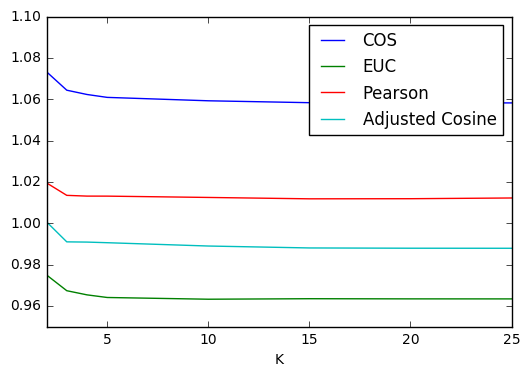

In [287]:
results_df1 = pd.DataFrame({'K': k, 'COS': cos_res, 'EUC': euc_res, 'scipycos': scipycos_res, 'Pearson': pr_res, 'Adjusted Cosine': adjcos_res})
results_df1.plot(x='K', y=['COS', 'EUC', 'Pearson', 'Adjusted Cosine'], ylim=(0.95, 1.1))

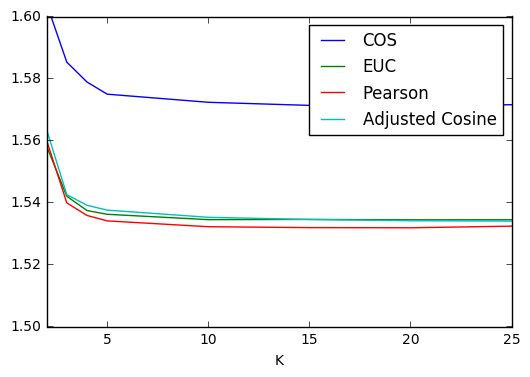

In [305]:
cos_res = sims_rmse[1]
euc_res = sims_rmse[0]
pr_res = sims_rmse[3]
adjcos_res = sims_rmse[4]
k = [2, 3, 4, 5, 10, 15, 20, 25]
results_df1 = pd.DataFrame({'K': k, 'COS': cos_res, 'EUC': euc_res, 'scipycos': scipycos_res, 'Pearson': pr_res, 'Adjusted Cosine': adjcos_res})
results_df1.plot(x='K', y=['COS', 'EUC', 'Pearson', 'Adjusted Cosine'], ylim=(1.5, 1.6))

We observe that there is no significant change in rmse and mae values beyond k =5, simple explaination of these can be that average books rated per user is around 3.3

In [398]:
import time
trtimer = []
tetimer = []
for data1 in datasets:
    rows1 = data1.user_id.unique()
    cols1 = data1['Book-Title'].unique()
    print(data1.user_id.nunique(), data1.isbn.nunique())
    data1 = data1[['user_id', 'Book-Title', 'book_rating']]
    
    idict  = dict(zip(cols1, range(len(cols1))))
    udict = dict(zip(rows1, range(len(rows1))))
    
    data1.user_id = [
    udict[i] for i in data1.user_id
    ]
    data1['Book-Title'] = [
    idict[i] for i in data1['Book-Title']
    ]
    
    nmat1 = data1.as_matrix()
    trt, tet = get_results(nmat, 'euc', len(rows1), len(cols1), 5, 5, True)
    
    trtimer.append(trt)
    tetimer.append(tet)

    print()

2517 100


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/pandas/core/generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


----------   Fold  1 ---------------
Training Time :  1.3631410598754883
Train Errors
RMSE : 0.3009
MAE : 0.1471
Prediction Time :  0.03231406211853027
Test Errors
RMSE : 1.5606
MAE : 0.9771

3086 150
----------   Fold  1 ---------------
Training Time :  2.8027307987213135
Train Errors
RMSE : 0.3009
MAE : 0.1471
Prediction Time :  0.0397031307220459
Test Errors
RMSE : 1.5606
MAE : 0.9771

3543 200
----------   Fold  1 ---------------
Training Time :  6.575017929077148
Train Errors
RMSE : 0.3009
MAE : 0.1471
Prediction Time :  0.0395510196685791
Test Errors
RMSE : 1.5606
MAE : 0.9771

4280 300
----------   Fold  1 ---------------
Training Time :  23.72175693511963
Train Errors
RMSE : 0.3009
MAE : 0.1471
Prediction Time :  0.03625893592834473
Test Errors
RMSE : 1.5606
MAE : 0.9771

5282 500
----------   Fold  1 ---------------
Training Time :  48.64173698425293
Train Errors
RMSE : 0.3009
MAE : 0.1471
Prediction Time :  0.05124092102050781
Test Errors
RMSE : 1.5606
MAE : 0.9771



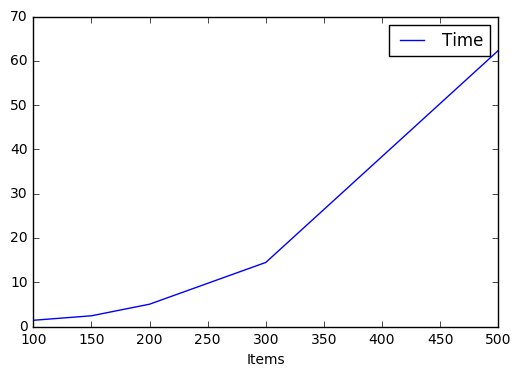

In [336]:
results_df1 = pd.DataFrame({'Items': [100, 150, 200, 300, 500], 'Time': trtimer})
results_df1.plot(x='Items', y='Time', ylim=(0, 70))

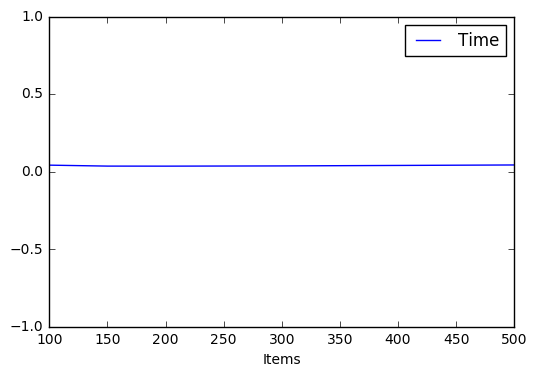

In [337]:
results_df1 = pd.DataFrame({'Items': [100, 150, 200, 300, 500], 'Time': tetimer})
results_df1.plot(x='Items', y='Time', ylim=(-1, 1))

getmrec function is used to get top m recommendation for a user_id based on the similarity matrix (option), k neighbours.

In [58]:
full_mat = np.zeros((len(rows),len(cols)))
for row in nmat:
    full_mat[row[0], row[1]] = row[2]
item_similarity, amean, umean, imean = itemsimilar(full_mat, 'euc')

In [59]:
def getmrec(full_mat, user_id, item_similarity, k, m, idict,  cov = False):
    
    n = item_similarity.shape[0]
    nzero = full_mat[user_id].nonzero()[0]
    
    preds = {}
    for row in range(n):
        preds[row] = predict(user_id, row, full_mat, item_similarity, amean, umean, imean, k)
    
    flipped_dict = dict(zip(idict.values(), idict.keys()))
    
    if not cov:
        print("Books Read -----")
        for i in nzero:
            print(flipped_dict[i])
            del preds[i]
    
    
    res = sorted(preds.items(), key=lambda x: x[1], reverse = True)
    
    ans = [flipped_dict[i[0]] for i in res[:m]]
    return ans

In [349]:
for m in [5, 8, 10, 15]:   
    cov = []
    for i in range(len(rows)):
        cov.extend(getmrec(full_mat, i, item_similarity, 5, m, idict, True))
    print("Coverage with", m, "recs:", len(set(cov)), "%")

Coverage with 5 recs: 92 %
Coverage with 8 recs: 95 %
Coverage with 10 recs: 99 %
Coverage with 15 recs: 100 %


In [75]:
getmrec(full_mat,udict[40914], item_similarity, k, 5, idict,  cov = False)  # item-item

Books Read -----
Little Altars Everywhere: A Novel
The Lovely Bones: A Novel
One for the Money (Stephanie Plum Novels (Paperback))
She's Come Undone (Oprah's Book Club (Paperback))
Shopaholic Takes Manhattan (Summer Display Opportunity)
A Man Named Dave: A Story of Triumph and Forgiveness


['Middlesex: A Novel',
 'The Amazing Adventures of Kavalier &amp; Clay',
 'Fast Food Nation: The Dark Side of the All-American Meal',
 'Good Omens',
 'The Hobbit : The Enchanting Prelude to The Lord of the Rings']

In [76]:
read_books = ["Little Altars Everywhere: A Novel",
"The Lovely Bones: A Novel'",
"One for the Money (Stephanie Plum Novels (Paperback))",
"She's Come Undone (Oprah's Book Club (Paperback))",
"Shopaholic Takes Manhattan (Summer Display Opportunity)",
"A Man Named Dave: A Story of Triumph and Forgiveness"]

In [ ]:
rec_books = []

In [74]:
#94853
#129538
#157602
#40914

udict

{3373: 0,
 6242: 1,
 11676: 2,
 21870: 3,
 22625: 4,
 28056: 5,
 36907: 6,
 40330: 7,
 40612: 8,
 52832: 9,
 63956: 10,
 80683: 11,
 86243: 12,
 92810: 13,
 95932: 14,
 99946: 15,
 100459: 16,
 102359: 17,
 102430: 18,
 105214: 19,
 105517: 20,
 107258: 21,
 119858: 22,
 124298: 23,
 129716: 24,
 132930: 25,
 146932: 26,
 148744: 27,
 157799: 28,
 159732: 29,
 165319: 30,
 174326: 31,
 178667: 32,
 204909: 33,
 224138: 34,
 240401: 35,
 241214: 36,
 250764: 37,
 264543: 38,
 266283: 39,
 269799: 40,
 271144: 41,
 277042: 42,
 1435: 43,
 1733: 44,
 2766: 45,
 11224: 46,
 11993: 47,
 20147: 48,
 21404: 49,
 22012: 50,
 25583: 51,
 26371: 52,
 30972: 53,
 31826: 54,
 32329: 55,
 37293: 56,
 37538: 57,
 37950: 58,
 38023: 59,
 40299: 60,
 41757: 61,
 42651: 62,
 46398: 63,
 51803: 64,
 52425: 65,
 52635: 66,
 53042: 67,
 54453: 68,
 55187: 69,
 56399: 70,
 59559: 71,
 60050: 72,
 65258: 73,
 69378: 74,
 70222: 75,
 70649: 76,
 75842: 77,
 79821: 78,
 80555: 79,
 88693: 80,
 91634: 81,
 924

In [254]:
from surprise import evaluate, Reader, Dataset, SVD, NMF, GridSearch, KNNWithMeans

In [361]:
reader = Reader(rating_scale=(1, 10))
data2 = Dataset.load_from_df(data[['user_id', 'Book-Title', 'book_rating']], reader)
data2.split(5)


In [365]:
param_grid = {'n_factors': [30, 40, 50, 60, 70], 'n_epochs': [40, 50, 60], 'reg_pu': [0.001, 0.1, 1],
              'reg_qi': [ 0.1, 1, 3, 5]}
grid_search = GridSearch(NMF, param_grid, measures=['RMSE', 'MAE'])
grid_search.evaluate(data2)
results_df = pd.DataFrame.from_dict(grid_search.cv_results)
print(results_df)

[{'n_epochs': 40, 'n_factors': 30, 'reg_pu': 0.001, 'reg_qi': 0.1}, {'n_epochs': 50, 'n_factors': 30, 'reg_pu': 0.001, 'reg_qi': 0.1}, {'n_epochs': 60, 'n_factors': 30, 'reg_pu': 0.001, 'reg_qi': 0.1}, {'n_epochs': 40, 'n_factors': 30, 'reg_pu': 0.1, 'reg_qi': 0.1}, {'n_epochs': 50, 'n_factors': 30, 'reg_pu': 0.1, 'reg_qi': 0.1}, {'n_epochs': 60, 'n_factors': 30, 'reg_pu': 0.1, 'reg_qi': 0.1}, {'n_epochs': 40, 'n_factors': 30, 'reg_pu': 1, 'reg_qi': 0.1}, {'n_epochs': 50, 'n_factors': 30, 'reg_pu': 1, 'reg_qi': 0.1}, {'n_epochs': 60, 'n_factors': 30, 'reg_pu': 1, 'reg_qi': 0.1}, {'n_epochs': 40, 'n_factors': 40, 'reg_pu': 0.001, 'reg_qi': 0.1}, {'n_epochs': 50, 'n_factors': 40, 'reg_pu': 0.001, 'reg_qi': 0.1}, {'n_epochs': 60, 'n_factors': 40, 'reg_pu': 0.001, 'reg_qi': 0.1}, {'n_epochs': 40, 'n_factors': 40, 'reg_pu': 0.1, 'reg_qi': 0.1}, {'n_epochs': 50, 'n_factors': 40, 'reg_pu': 0.1, 'reg_qi': 0.1}, {'n_epochs': 60, 'n_factors': 40, 'reg_pu': 0.1, 'reg_qi': 0.1}, {'n_epochs': 40, '

KeyboardInterrupt: 

In [124]:
print(grid_search.best_score['RMSE'])
print(grid_search.best_params['RMSE'])
print(grid_search.best_score['MAE'])
print(grid_search.best_params['MAE'])


1.52494930355
{'n_epochs': 40, 'n_factors': 60, 'reg_pu': 0.001, 'reg_qi': 5}
0.96982279914
{'n_epochs': 60, 'n_factors': 70, 'reg_pu': 0.001, 'reg_qi': 5}


In [367]:
maelist = []
rmselist = []
factors = [20, 30, 40 ,50 ,60, 70, 80]
for i in factors:
    algo = NMF(n_factors = i, reg_pu = 0.001, reg_qi = 5)
    perf = evaluate(algo, data2)
    maelist.append(np.mean(perf['mae']))
    rmselist.append(np.mean(perf['rmse']))
    

Evaluating RMSE, MAE of algorithm NMF.

------------
Fold 1
RMSE: 1.5295
MAE:  0.9953
------------
Fold 2
RMSE: 1.6235
MAE:  1.0283
------------
Fold 3
RMSE: 1.5850
MAE:  1.0468
------------
Fold 4
RMSE: 1.6448
MAE:  1.0568
------------
Fold 5
RMSE: 1.5809
MAE:  1.0215
------------
------------
Mean RMSE: 1.5927
Mean MAE : 1.0297
------------
------------
Evaluating RMSE, MAE of algorithm NMF.

------------
Fold 1
RMSE: 1.5299
MAE:  0.9802
------------
Fold 2
RMSE: 1.5809
MAE:  0.9931
------------
Fold 3
RMSE: 1.5895
MAE:  1.0383
------------
Fold 4
RMSE: 1.6405
MAE:  1.0534
------------
Fold 5
RMSE: 1.5381
MAE:  0.9795
------------
------------
Mean RMSE: 1.5758
Mean MAE : 1.0089
------------
------------
Evaluating RMSE, MAE of algorithm NMF.

------------
Fold 1
RMSE: 1.5071
MAE:  0.9646
------------
Fold 2
RMSE: 1.5856
MAE:  0.9926
------------
Fold 3
RMSE: 1.5724
MAE:  1.0168
------------
Fold 4
RMSE: 1.6136
MAE:  1.0321
------------
Fold 5
RMSE: 1.5300
MAE:  0.9770
------------
-

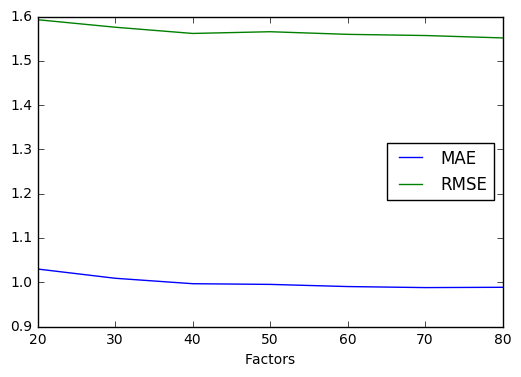

In [368]:
results_df = pd.DataFrame({'Factors': factors, 'MAE': maelist, 'RMSE': rmselist})
results_df.plot(x='Factors', y=['MAE', 'RMSE'], ylim=(0.9, 1.6))

In [369]:
maelist

[1.0297361754276078,
 1.0089101104606384,
 0.99662862243944694,
 0.99508467515178689,
 0.99018986323937952,
 0.98785902918736546,
 0.9885348135994988]

In [370]:
from collections import defaultdict
def get_top_n(predictions, n=10):

    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


trainset = data2.build_full_trainset()
algo = NMF(n_epochs = 60, n_factors = 70, reg_pu = 0.001, reg_qi = 5)
algo.train(trainset)

# Than predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

top_n = get_top_n(predictions, n=10)

# Print the recommended items for each user


In [386]:
def recbooks(mat, user_id, idict, cov = False):    # NMF
    full_mat = np.zeros((len(rows),len(cols)))
    for row in mat:
        full_mat[row[0], row[1]] = row[2]
    
    nzero = full_mat[user_id].nonzero()[0]
    
    flipped_dict = dict(zip(idict.values(), idict.keys()))
    ans = [flipped_dict[i[0]] for i in top_n[user_id]]
    if not cov:
        print("Books Read -----")
        for i in nzero:
            print(flipped_dict[i])
        print()
        print("Recs -----")
        for i in ans:
            print(i)
    return ans

recbooks(nmat, 1,idict)

['A Wrinkle In Time',
 'Harry Potter and the Goblet of Fire (Book 4)',
 "The Clan of the Cave Bear (Earth's Children (Paperback))",
 'Tears of the Giraffe (No.1 Ladies Detective Agency)',
 'The Lovely Bones: A Novel',
 'Into Thin Air : A Personal Account of the Mt. Everest Disaster',
 'Prodigal Summer: A Novel',
 'Fast Food Nation: The Dark Side of the All-American Meal',
 "Where the Heart Is (Oprah's Book Club (Paperback))",
 'The Poisonwood Bible: A Novel']

In [388]:
for m in [5, 8, 10, 15]:   
    cov = []
    top_n = get_top_n(predictions, m)
    for i in range(len(rows)):
        cov.extend(recbooks(nmat, i,idict, True))
    print("Coverage with", m, "recs:", len(set(cov)), "%")

Coverage with 5 recs: 79 %
Coverage with 8 recs: 86 %
Coverage with 10 recs: 89 %
Coverage with 15 recs: 92 %


In [400]:
trtimer = []
tetimer = []
for data4 in datasets:
    rows4 = data4.user_id.unique()
    cols4 = data4['Book-Title'].unique()
    print(data4.user_id.nunique(), data4.isbn.nunique())
    data4 = data4[['user_id', 'Book-Title', 'book_rating']]
    
    idict  = dict(zip(cols4, range(len(cols4))))
    udict = dict(zip(rows4, range(len(rows4))))
    
    data4.user_id = [
    udict[i] for i in data4.user_id
    ]
    data4['Book-Title'] = [
    idict[i] for i in data4['Book-Title']
    ]
    
    trainset = data2.build_full_trainset()
    algo = NMF(n_epochs = 60, n_factors = 70, reg_pu = 0.001, reg_qi = 5)
    
    start = time.time()
    algo.train(trainset)
    end = time.time()
    
    trt = end - start
    print(trt)
    
    testset = trainset.build_anti_testset()
    
    start = time.time()
    predictions = algo.test(testset)
    end = time.time()
    
    tet = end - start
    print(tet)
    
    trtimer.append(trt)
    tetimer.append(tet)

    print()


2517 100


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/pandas/core/generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


2.27958607673645
2.0923609733581543

3086 150
1.97456693649292
1.9721879959106445

3543 200
1.9641799926757812
1.9771080017089844

4280 300
2.2696471214294434
1.9798550605773926

5282 500
2.246142864227295
2.1920011043548584



In [264]:
sim_options = {
    'name': 'cosine',
    'user_based' : False
}
algo = KNNWithMeans(sim_options = sim_options, k = 10, min_k =2)

In [265]:
perf = evaluate(algo, data1)

Evaluating RMSE, MAE of algorithm KNNWithMeans.

------------
Fold 1
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.7372
MAE:  1.3223
------------
Fold 2
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.7156
MAE:  1.3193
------------
Fold 3
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.7178
MAE:  1.2922
------------
Fold 4
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.7564
MAE:  1.3310
------------
Fold 5
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.6436
MAE:  1.2495
------------
------------
Mean RMSE: 1.7141
Mean MAE : 1.3028
------------
------------


In [396]:
rmse

[1.5927372600247496,
 1.5757767529494611,
 1.5617249459059299,
 1.5656226172291765,
 1.5596867488168866,
 1.5570432370533862,
 1.5516455675490717]